#RoBERTa Model based on Utterance alone

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.687200
100,0.645700
150,0.531900
200,0.409300
250,0.273200
300,0.154100
350,0.128700
400,0.081500
450,0.081800
500,0.085900


Test Accuracy: 0.9227052927017212

Classification Report:
               precision    recall  f1-score   support

Non-Sarcastic       0.92      0.94      0.93       233
    Sarcastic       0.92      0.90      0.91       181

     accuracy                           0.92       414
    macro avg       0.92      0.92      0.92       414
 weighted avg       0.92      0.92      0.92       414



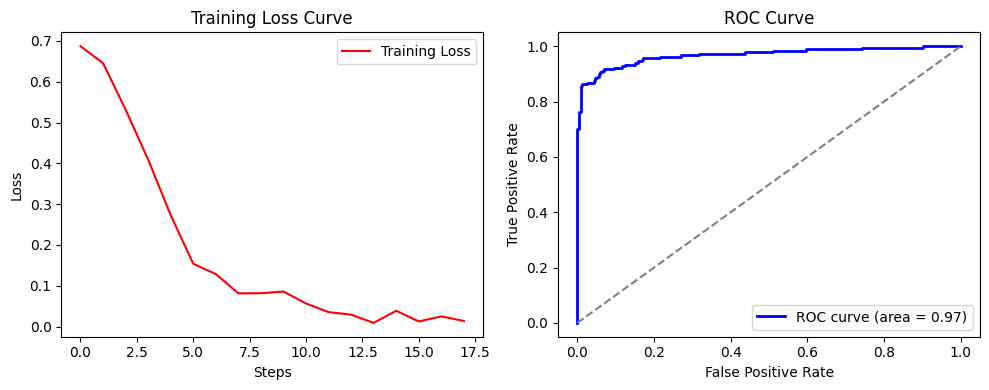

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import numpy as np

# Load tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Custom callback to track training loss
class LogLossCallback(TrainerCallback):
    def __init__(self):
        self.train_loss_history = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.train_loss_history.append(logs['loss'])

    def get_train_loss_history(self):
        return self.train_loss_history

# Load and prepare data
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['utterance', 'sarcasm']]
    df['sarcasm'] = df['sarcasm'].astype(int)
    return df

def preprocess_data(texts, tokenizer):
    return tokenizer(list(texts), padding=True, truncation=True, max_length=128)

def prepare_datasets(file_path, tokenizer):
    df = load_data(file_path)
    train_texts, test_texts, train_labels, test_labels = train_test_split(df['utterance'], df['sarcasm'], test_size=0.2, random_state=42)
    train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.1, random_state=42)

    train_enc = preprocess_data(train_texts, tokenizer)
    val_enc = preprocess_data(val_texts, tokenizer)
    test_enc = preprocess_data(test_texts, tokenizer)

    train_dataset = Dataset.from_dict({"input_ids": train_enc['input_ids'], "attention_mask": train_enc['attention_mask'], "labels": list(train_labels)})
    val_dataset = Dataset.from_dict({"input_ids": val_enc['input_ids'], "attention_mask": val_enc['attention_mask'], "labels": list(val_labels)})
    test_dataset = Dataset.from_dict({"input_ids": test_enc['input_ids'], "attention_mask": test_enc['attention_mask'], "labels": list(test_labels)})

    return DatasetDict({"train": train_dataset, "validation": val_dataset, "test": test_dataset}), list(test_labels)

# Compute metrics
def compute_metrics(pred):
    predictions = torch.argmax(torch.tensor(pred.predictions), dim=1)
    labels = torch.tensor(pred.label_ids)
    accuracy = (predictions == labels).float().mean().item()
    return {"accuracy": accuracy}

# Prepare datasets
datasets, true_labels = prepare_datasets("/content/augmented_sarcasm_data.csv", tokenizer)

# Load model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Training arguments for Transformers v4.5.1
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_steps=500,
    eval_steps=500,
    logging_dir="./logs",
    logging_steps=50,
    report_to=[],
)

# Callback for tracking training loss
log_loss_callback = LogLossCallback()

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["validation"],
    compute_metrics=compute_metrics,
    callbacks=[log_loss_callback]
)

# Train the model
trainer.train()

# Evaluate on test set
test_results = trainer.evaluate(datasets["test"])
print("Test Accuracy:", test_results["eval_accuracy"])

# Predictions
predictions = trainer.predict(datasets["test"])
pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1).tolist()

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=["Non-Sarcastic", "Sarcastic"]))

# Plot training loss curve and ROC
plt.figure(figsize=(10, 4))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(log_loss_callback.get_train_loss_history(), label="Training Loss", color="red")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predictions.predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


#Model based on Utterance and Context

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.692800
100,0.584700
150,0.448700
200,0.339800
250,0.174100
300,0.130400
350,0.070700
400,0.054400
450,0.029600
500,0.007800


Test Accuracy: 0.9541062712669373

Classification Report:
               precision    recall  f1-score   support

Non-Sarcastic       0.94      0.98      0.96       233
    Sarcastic       0.98      0.92      0.95       181

     accuracy                           0.95       414
    macro avg       0.96      0.95      0.95       414
 weighted avg       0.96      0.95      0.95       414



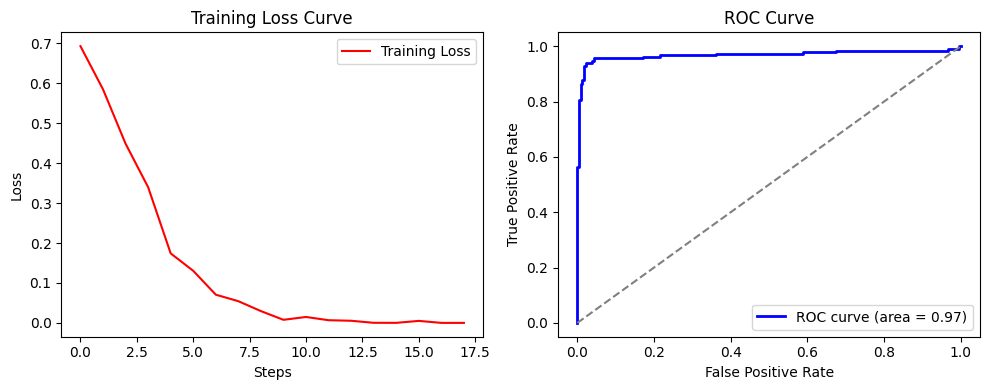

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import numpy as np

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Custom callback to track training loss
class LogLossCallback(TrainerCallback):
    def __init__(self):
        self.train_loss_history = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.train_loss_history.append(logs['loss'])

    def get_train_loss_history(self):
        return self.train_loss_history

# Load and prepare data
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['context', 'utterance', 'sarcasm']]
    df['sarcasm'] = df['sarcasm'].astype(int)
    sep_token = tokenizer.sep_token  # e.g., </s> for Roberta
    df['combined'] = df['context'].fillna('') + f" {sep_token} " + df['utterance']
    return df

def preprocess_data(texts, tokenizer):
    return tokenizer(list(texts), padding=True, truncation=True, max_length=128)

def prepare_datasets(file_path, tokenizer):
    df = load_data(file_path)
    train_texts, test_texts, train_labels, test_labels = train_test_split(df['combined'], df['sarcasm'], test_size=0.2, random_state=42)
    train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.1, random_state=42)

    train_enc = preprocess_data(train_texts, tokenizer)
    val_enc = preprocess_data(val_texts, tokenizer)
    test_enc = preprocess_data(test_texts, tokenizer)

    train_dataset = Dataset.from_dict({
        "input_ids": train_enc['input_ids'],
        "attention_mask": train_enc['attention_mask'],
        "labels": list(train_labels)
    })
    val_dataset = Dataset.from_dict({
        "input_ids": val_enc['input_ids'],
        "attention_mask": val_enc['attention_mask'],
        "labels": list(val_labels)
    })
    test_dataset = Dataset.from_dict({
        "input_ids": test_enc['input_ids'],
        "attention_mask": test_enc['attention_mask'],
        "labels": list(test_labels)
    })

    return DatasetDict({
        "train": train_dataset,
        "validation": val_dataset,
        "test": test_dataset
    }), list(test_labels)

# Compute metrics
def compute_metrics(pred):
    predictions = torch.argmax(torch.tensor(pred.predictions), dim=1)
    labels = torch.tensor(pred.label_ids)
    accuracy = (predictions == labels).float().mean().item()
    return {"accuracy": accuracy}

# Prepare datasets
datasets, true_labels = prepare_datasets("/content/augmented_sarcasm_data.csv", tokenizer)

# Load model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_steps=500,
    eval_steps=500,
    logging_dir="./logs",
    logging_steps=50,
    report_to=[],
)

# Callback for tracking training loss
log_loss_callback = LogLossCallback()

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["validation"],
    compute_metrics=compute_metrics,
    callbacks=[log_loss_callback]
)

# Train the model
trainer.train()

# Evaluate on test set
test_results = trainer.evaluate(datasets["test"])
print("Test Accuracy:", test_results["eval_accuracy"])

# Predictions
predictions = trainer.predict(datasets["test"])
pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1).tolist()

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=["Non-Sarcastic", "Sarcastic"]))

# Plot training loss and ROC curve
plt.figure(figsize=(10, 4))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(log_loss_callback.get_train_loss_history(), label="Training Loss", color="red")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predictions.predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


#Model Based on Context and Utterane Embedded with Speakers

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.669600
100,0.529800
150,0.433900
200,0.329300
250,0.189200
300,0.131900
350,0.115100
400,0.042300
450,0.035100
500,0.019900


Test Accuracy: 0.966183602809906

Classification Report:
               precision    recall  f1-score   support

Non-Sarcastic       0.96      0.98      0.97       233
    Sarcastic       0.97      0.95      0.96       181

     accuracy                           0.97       414
    macro avg       0.97      0.96      0.97       414
 weighted avg       0.97      0.97      0.97       414



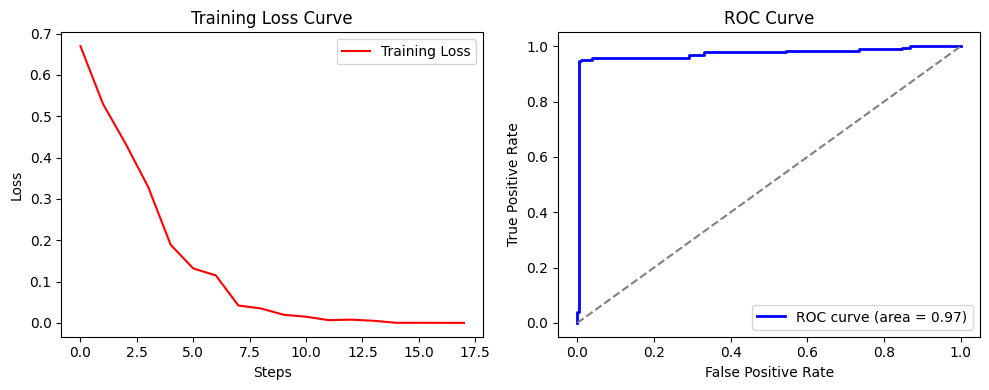

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import ast
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import numpy as np

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Custom callback to track training loss
class LogLossCallback(TrainerCallback):
    def __init__(self):
        self.train_loss_history = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.train_loss_history.append(logs['loss'])

    def get_train_loss_history(self):
        return self.train_loss_history

# Load and prepare data
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['context_mapping', 'speaker', 'utterance', 'sarcasm']]
    df['sarcasm'] = df['sarcasm'].astype(int)
    return df

# Preprocess the data: context + [SEP] + speaker: utterance
def preprocess_data(df, tokenizer):
    sep = tokenizer.sep_token

    def flatten_context(context_mapping_str):
        try:
            context_list = ast.literal_eval(context_mapping_str)
            return " ".join(
                f"{item.get('speaker', '')}: {item.get('utterance', '')}"
                for item in context_list
            )
        except Exception:
            return ""

    combined = df.apply(
        lambda x: f"{flatten_context(x['context_mapping'])} {sep} {x['speaker']}: {x['utterance']}",
        axis=1
    ).tolist()

    encodings = tokenizer(combined, padding=True, truncation=True, max_length=128)
    return encodings

# Prepare datasets
def prepare_datasets(file_path, tokenizer):
    df = load_data(file_path)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

    train_enc = preprocess_data(train_df, tokenizer)
    val_enc = preprocess_data(val_df, tokenizer)
    test_enc = preprocess_data(test_df, tokenizer)

    train_dataset = Dataset.from_dict({
        "input_ids": train_enc['input_ids'],
        "attention_mask": train_enc['attention_mask'],
        "labels": list(train_df['sarcasm'])
    })
    val_dataset = Dataset.from_dict({
        "input_ids": val_enc['input_ids'],
        "attention_mask": val_enc['attention_mask'],
        "labels": list(val_df['sarcasm'])
    })
    test_dataset = Dataset.from_dict({
        "input_ids": test_enc['input_ids'],
        "attention_mask": test_enc['attention_mask'],
        "labels": list(test_df['sarcasm'])
    })

    return DatasetDict({
        "train": train_dataset,
        "validation": val_dataset,
        "test": test_dataset
    }), list(test_df['sarcasm'])

# Compute metrics
def compute_metrics(pred):
    predictions = torch.argmax(torch.tensor(pred.predictions), dim=1)
    labels = torch.tensor(pred.label_ids)
    accuracy = (predictions == labels).float().mean().item()
    return {"accuracy": accuracy}

# Prepare datasets
datasets, true_labels = prepare_datasets("/content/augmented_sarcasm_data.csv", tokenizer)

# Load model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_steps=500,
    eval_steps=500,
    logging_dir="./logs",
    logging_steps=50,
    report_to=[],
)

# Callback for tracking training loss
log_loss_callback = LogLossCallback()

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["validation"],
    compute_metrics=compute_metrics,
    callbacks=[log_loss_callback]
)

# Train the model
trainer.train()

# Evaluate on test set
test_results = trainer.evaluate(datasets["test"])
print("Test Accuracy:", test_results["eval_accuracy"])

# Predictions
predictions = trainer.predict(datasets["test"])
pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1).tolist()

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=["Non-Sarcastic", "Sarcastic"]))

# Plot training loss and ROC curve
plt.figure(figsize=(10, 4))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(log_loss_callback.get_train_loss_history(), label="Training Loss", color="red")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predictions.predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


#Model Based on Summarized Context

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/5: 100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch 1 Loss: 0.6929


Epoch 2/5: 100%|██████████| 104/104 [02:02<00:00,  1.18s/it]


Epoch 2 Loss: 0.5962


Epoch 3/5: 100%|██████████| 104/104 [02:02<00:00,  1.18s/it]


Epoch 3 Loss: 0.4150


Epoch 4/5: 100%|██████████| 104/104 [02:02<00:00,  1.18s/it]


Epoch 4 Loss: 0.2552


Epoch 5/5: 100%|██████████| 104/104 [02:02<00:00,  1.18s/it]

Epoch 5 Loss: 0.2253


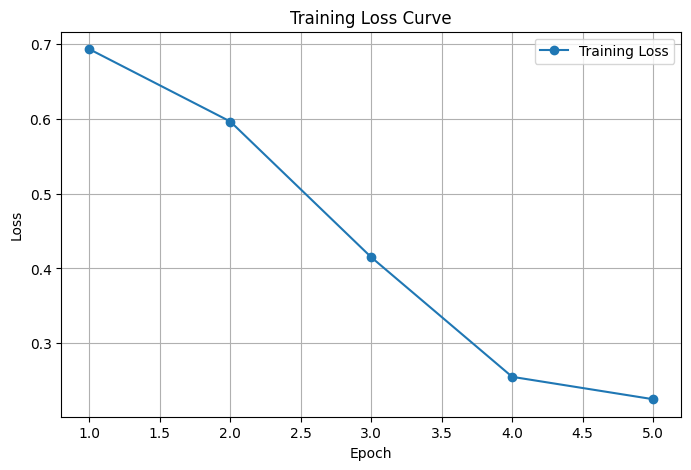


Validation Accuracy: 0.9710
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       207
           1       0.96      0.99      0.97       207

    accuracy                           0.97       414
   macro avg       0.97      0.97      0.97       414
weighted avg       0.97      0.97      0.97       414



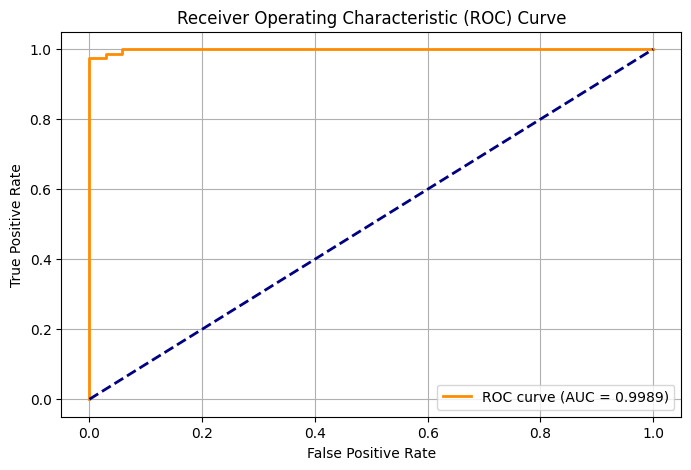

In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_scheduler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn.functional import softmax

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------
# Load Augmented Data
# --------------------
def load_data(file_path):
    df = pd.read_csv(file_path)
    required_columns = {'utterance_preprocessed', 'summary', 'speaker', 'sarcasm'}
    assert required_columns.issubset(df.columns), \
        f"Dataset must contain {required_columns}"
    return df

data_path = "augmented_sarcasm_data.csv"  # <-- use your augmented file
df = load_data(data_path)

# --------------------
# Speaker Mapping
# --------------------
unique_speakers = df['speaker'].unique()
speaker_map = {speaker: idx for idx, speaker in enumerate(unique_speakers)}

# --------------------
# Dataset
# --------------------
class SarcasmDataset(Dataset):
    def __init__(self, data, tokenizer, speaker_map, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.speaker_map = speaker_map
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        utterance = str(row['utterance_preprocessed'])
        inputs = self.tokenizer(
            utterance,
            row['summary'],
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        speaker_id = self.speaker_map[row['speaker']]
        label = torch.tensor(row['sarcasm'], dtype=torch.long)

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'speaker_id': torch.tensor(speaker_id, dtype=torch.long),
            'labels': label
        }

# --------------------
# Model
# --------------------
class SarcasmDetectionModel(torch.nn.Module):
    def __init__(self, roberta_model_name, num_labels, speaker_vocab_size, speaker_embedding_dim):
        super(SarcasmDetectionModel, self).__init__()
        self.roberta = RobertaForSequenceClassification.from_pretrained(roberta_model_name, num_labels=num_labels)
        self.speaker_embedding = torch.nn.Embedding(speaker_vocab_size, speaker_embedding_dim)
        self.classifier = torch.nn.Linear(self.roberta.config.hidden_size + speaker_embedding_dim, num_labels)

    def forward(self, input_ids, attention_mask, speaker_ids):
        roberta_outputs = self.roberta.roberta(input_ids, attention_mask=attention_mask)
        cls_output = roberta_outputs.last_hidden_state[:, 0, :]
        speaker_embeds = self.speaker_embedding(speaker_ids)
        combined_features = torch.cat((cls_output, speaker_embeds), dim=1)
        logits = self.classifier(combined_features)
        return logits

# --------------------
# Train-Test Split
# --------------------
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sarcasm'])

tokenizer = RobertaTokenizer.from_pretrained("roberta-large")
train_dataset = SarcasmDataset(train_df, tokenizer, speaker_map)
val_dataset = SarcasmDataset(val_df, tokenizer, speaker_map)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# --------------------
# Initialize Model
# --------------------
model = SarcasmDetectionModel(
    roberta_model_name="roberta-large",
    num_labels=2,
    speaker_vocab_size=len(speaker_map),
    speaker_embedding_dim=100
).to(device)

# Optimizer with different LRs
optimizer_grouped_parameters = [
    {"params": model.roberta.parameters(), "lr": 1e-5},
    {"params": model.classifier.parameters(), "lr": 2e-4},
    {"params": model.speaker_embedding.parameters(), "lr": 1e-3},
]
optimizer = AdamW(optimizer_grouped_parameters)

epochs = 5
num_training_steps = len(train_loader) * epochs
num_warmup_steps = int(0.1 * num_training_steps)

lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# --------------------
# Training
# --------------------
train_losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        speaker_ids = batch['speaker_id'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask, speaker_ids)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

# --------------------
# Loss Curve
# --------------------
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# --------------------
# Evaluation
# --------------------
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        speaker_ids = batch['speaker_id'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attention_mask, speaker_ids)
        probs = softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"\nValidation Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds))

# --------------------
# ROC Curve
# --------------------
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
